# Oct 12, 2025: draw hierarchy
per mode between Level 1 to Level 2

conda env: gt

In [1]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np 
import os

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from cycler import cycler
import matplotlib.colors as mcolors
import matplotlib.cm as cm

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)


In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

In [3]:
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

In [4]:
import seaborn as sns

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [6]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'

In [8]:
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [9]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [10]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

In [11]:
labels = [f'C. {i+1:02d}' for i in range(9)]

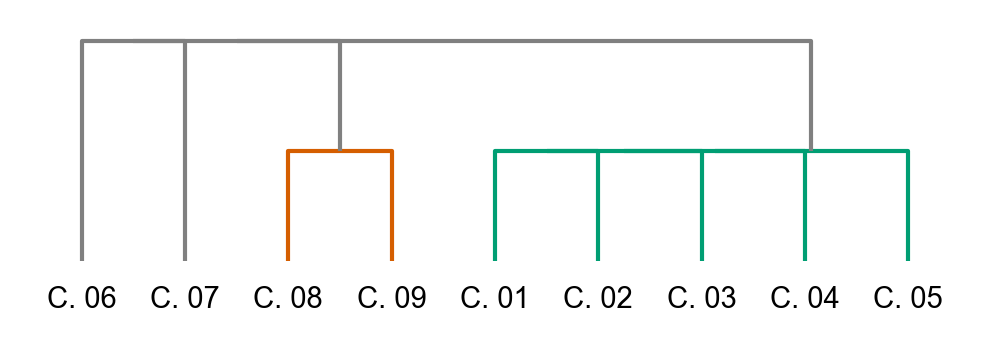

In [12]:
mode = 0 
Z = np.array([
    [0, 1, 1.0, 2],
    [9, 2, 1, 3],
    [10, 3, 1, 4],
    [11, 4, 1, 5],
    [7, 8, 1, 2],
    [5, 6, 2, 2],
    [14, 13, 2, 4],
    [15, 12, 2, 9],
])

fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7., # font size for the x axis labels
    ax=ax,
    color_threshold=1.5,
    above_threshold_color='grey',
)
ax.set(yticks=[])
sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.png', transparent=True, dpi=300, bbox_inches='tight')

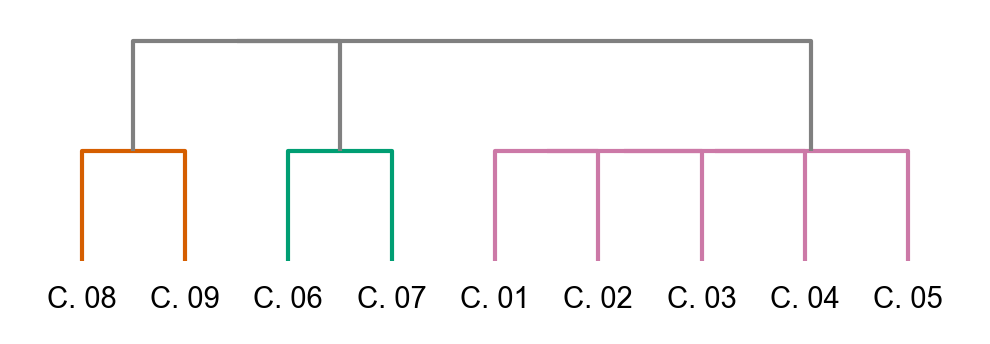

In [13]:
mode = 1 
Z = np.array([
    [0, 1, 1.0, 2],
    [9, 2, 1, 3],
    [10, 3, 1, 4],
    [11, 4, 1, 5],
    [5, 6, 1, 2],
    [7, 8, 1, 2],
    [14, 13, 2, 4],
    [15, 12, 2, 9],
])

fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7., # font size for the x axis labels
    ax=ax,
    color_threshold=1.5,
    above_threshold_color='grey',
)
ax.set(yticks=[])
sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.png', transparent=True, dpi=300, bbox_inches='tight')

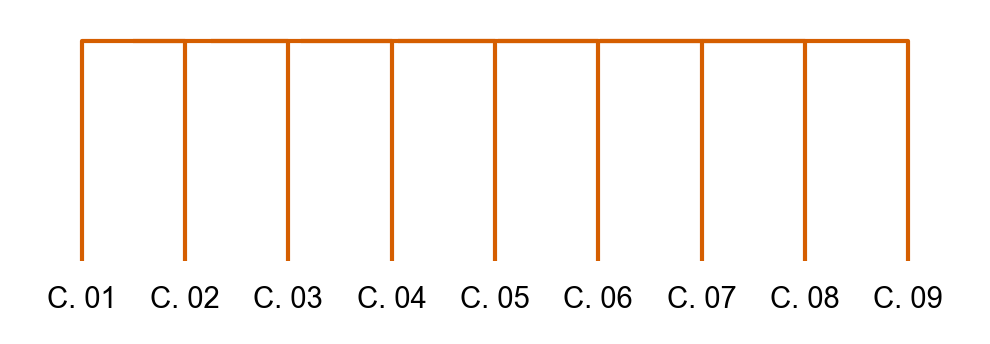

In [14]:
mode = 2 
Z = np.array([
    [0, 1, 1.0, 2],
    [9, 2, 1, 3],
    [10, 3, 1, 4],
    [11, 4, 1, 5],
    [12, 5, 1, 6],
    [13, 6, 1, 7],
    [14, 7, 1, 8],
    [15, 8, 1, 9],
])

fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7., # font size for the x axis labels
    ax=ax,
    color_threshold=1.5,
    above_threshold_color='grey',
)
ax.set(yticks=[])
sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.png', transparent=True, dpi=300, bbox_inches='tight')

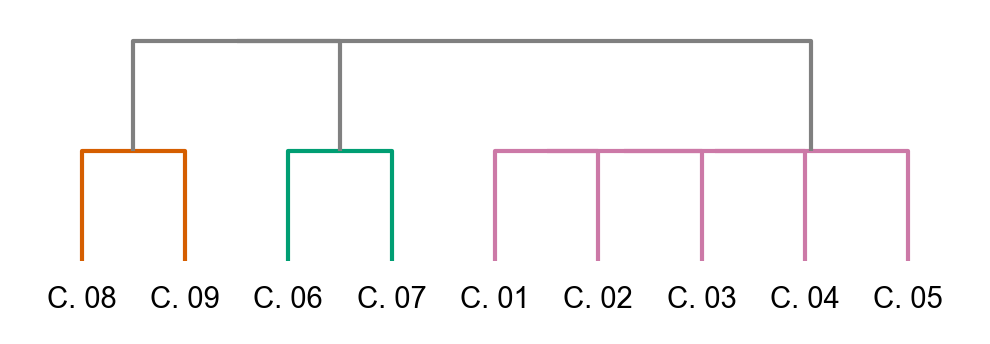

In [15]:
mode = 3 
Z = np.array([
    [0, 1, 1.0, 2],
    [9, 2, 1, 3],
    [10, 3, 1, 4],
    [11, 4, 1, 5],
    [5, 6, 1, 2],
    [7, 8, 1, 2],
    [14, 13, 2, 4],
    [15, 12, 2, 9],
])

fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7., # font size for the x axis labels
    ax=ax,
    color_threshold=1.5,
    above_threshold_color='grey',
)
ax.set(yticks=[])
sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.png', transparent=True, dpi=300, bbox_inches='tight')

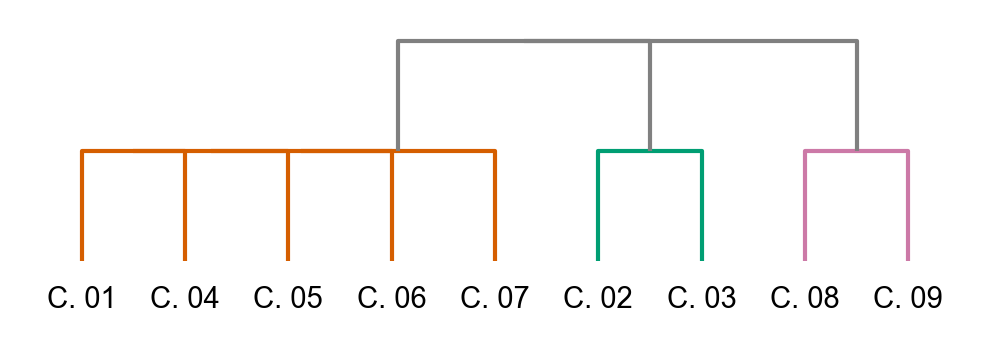

In [16]:
mode = 4 
Z = np.array([
    [1, 2, 1.0, 2],
    [0, 3, 1, 2],
    [10, 4, 1, 3],
    [11, 5, 1, 4],
    [12, 6, 1, 5],
    [7, 8, 1, 2],
    [13, 9, 2, 7],
    [15, 14, 2, 9],
])

fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7., # font size for the x axis labels
    ax=ax,
    color_threshold=1.5,
    above_threshold_color='grey',
)
ax.set(yticks=[])
sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.png', transparent=True, dpi=300, bbox_inches='tight')

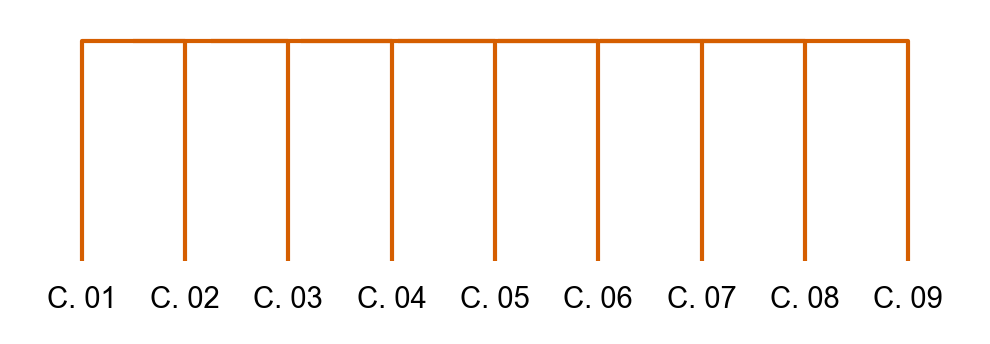

In [17]:
mode = 5 
Z = np.array([
    [0, 1, 1.0, 2],
    [9, 2, 1, 3],
    [10, 3, 1, 4],
    [11, 4, 1, 5],
    [12, 5, 1, 6],
    [13, 6, 1, 7],
    [14, 7, 1, 8],
    [15, 8, 1, 9],
])

fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7., # font size for the x axis labels
    ax=ax,
    color_threshold=1.5,
    above_threshold_color='grey',
)
ax.set(yticks=[])
sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.png', transparent=True, dpi=300, bbox_inches='tight')

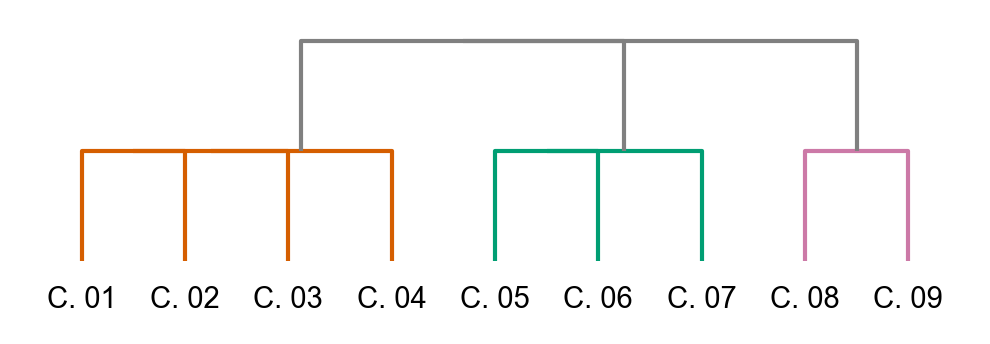

In [18]:
mode = 6 
Z = np.array([
    [0, 1, 1.0, 2],
    [9, 2, 1, 3],
    [10, 3, 1, 4],
    [4, 5, 1, 2],
    [12, 6, 1, 3],
    [7, 8, 1, 2],
    [11, 13, 2, 7],
    [15, 14, 2, 9],
])

fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7., # font size for the x axis labels
    ax=ax,
    color_threshold=1.5,
    above_threshold_color='grey',
)
ax.set(yticks=[])
sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.png', transparent=True, dpi=300, bbox_inches='tight')

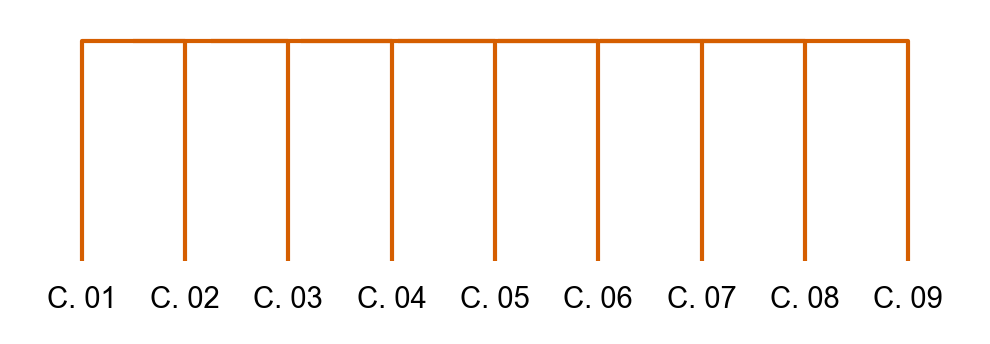

In [19]:
mode = 7 
Z = np.array([
    [0, 1, 1.0, 2],
    [9, 2, 1, 3],
    [10, 3, 1, 4],
    [11, 4, 1, 5],
    [12, 5, 1, 6],
    [13, 6, 1, 7],
    [14, 7, 1, 8],
    [15, 8, 1, 9],
])

fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7., # font size for the x axis labels
    ax=ax,
    color_threshold=1.5,
    above_threshold_color='grey',
)
ax.set(yticks=[])
sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.png', transparent=True, dpi=300, bbox_inches='tight')

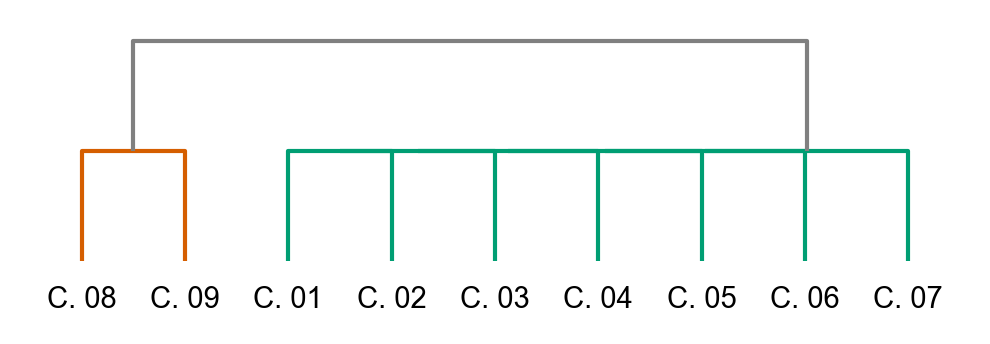

In [20]:
mode = 8 
Z = np.array([
    [0, 1, 1.0, 2],
    [9, 2, 1, 3],
    [10, 3, 1, 4],
    [11, 4, 1, 5],
    [12, 5, 1, 6],
    [13, 6, 1, 7],
    [7, 8, 1, 2],
    [15, 14, 2, 9],
])

fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7., # font size for the x axis labels
    ax=ax,
    color_threshold=1.5,
    above_threshold_color='grey',
)
ax.set(yticks=[])
sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.png', transparent=True, dpi=300, bbox_inches='tight')

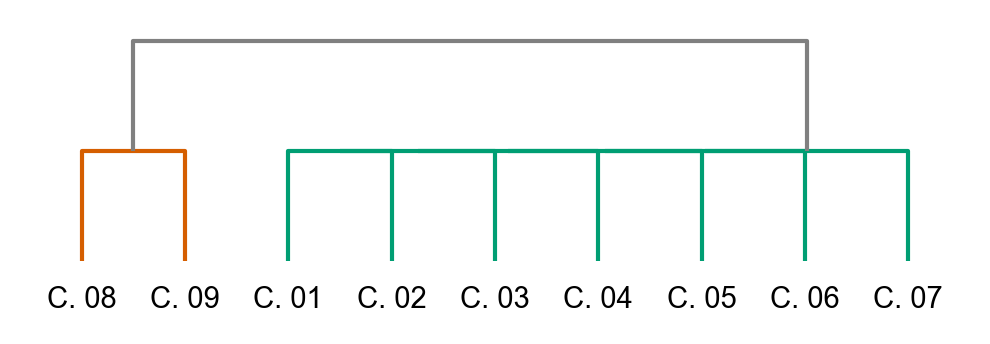

In [21]:
mode = 9 
Z = np.array([
    [0, 1, 1.0, 2],
    [9, 2, 1, 3],
    [10, 3, 1, 4],
    [11, 4, 1, 5],
    [12, 5, 1, 6],
    [13, 6, 1, 7],
    [7, 8, 1, 2],
    [15, 14, 2, 9],
])

fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7., # font size for the x axis labels
    ax=ax,
    color_threshold=1.5,
    above_threshold_color='grey',
)
ax.set(yticks=[])
sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.png', transparent=True, dpi=300, bbox_inches='tight')

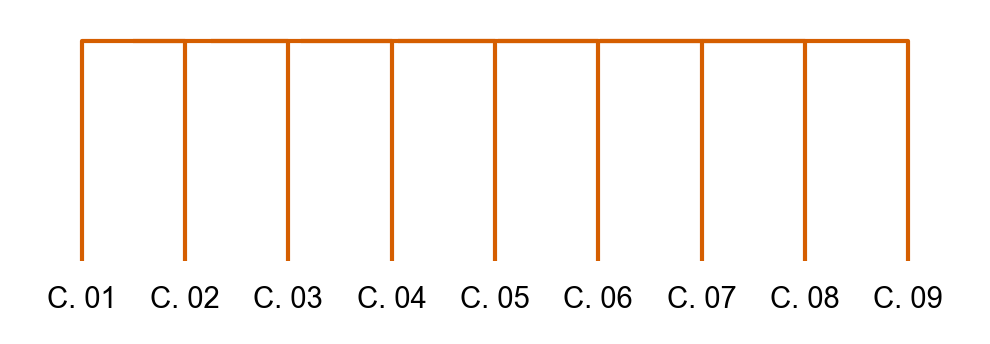

In [22]:
mode = 10 
Z = np.array([
    [0, 1, 1.0, 2],
    [9, 2, 1, 3],
    [10, 3, 1, 4],
    [11, 4, 1, 5],
    [12, 5, 1, 6],
    [13, 6, 1, 7],
    [14, 7, 1, 8],
    [15, 8, 1, 9],
])

fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7., # font size for the x axis labels
    ax=ax,
    color_threshold=1.5,
    above_threshold_color='grey',
)
ax.set(yticks=[])
sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.png', transparent=True, dpi=300, bbox_inches='tight')

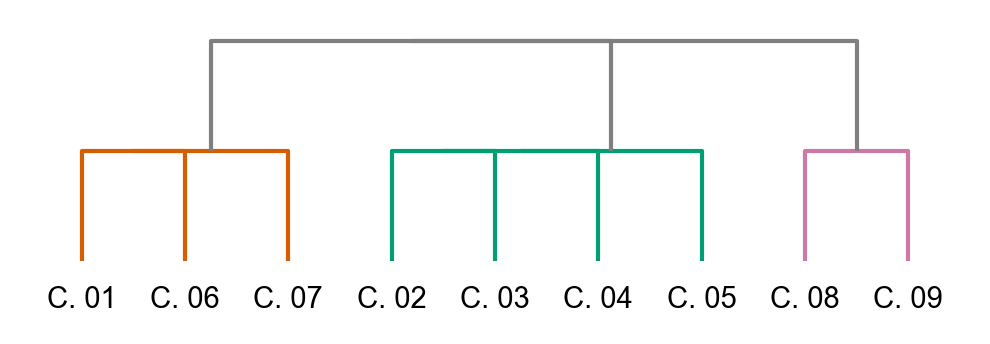

In [23]:
mode = 11 
Z = np.array([
    [0, 5, 1.0, 2],
    [9, 6, 1, 3],
    [1, 2, 1, 2],
    [11, 3, 1, 3],
    [12, 4, 1, 4],
    [7, 8, 1, 2],
    [10, 13, 2, 7],
    [15, 14, 2, 9],
])

fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7., # font size for the x axis labels
    ax=ax,
    color_threshold=1.5,
    above_threshold_color='grey',
)
ax.set(yticks=[])
sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.png', transparent=True, dpi=300, bbox_inches='tight')

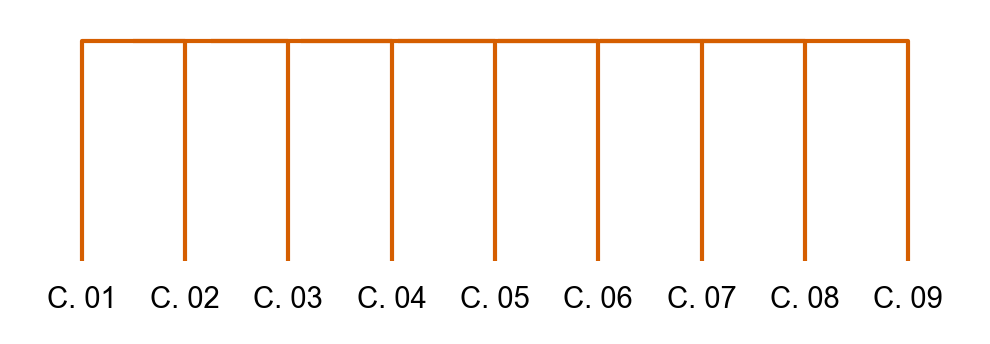

In [24]:
mode = 12 
Z = np.array([
    [0, 1, 1.0, 2],
    [9, 2, 1, 3],
    [10, 3, 1, 4],
    [11, 4, 1, 5],
    [12, 5, 1, 6],
    [13, 6, 1, 7],
    [14, 7, 1, 8],
    [15, 8, 1, 9],
])

fig, ax = plt.subplots(1, 1, figsize=(4, 1), dpi=300)

dendrogram(
    Z,
    labels=labels,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=7., # font size for the x axis labels
    ax=ax,
    color_threshold=1.5,
    above_threshold_color='grey',
)
ax.set(yticks=[])
sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/mode-{mode:02d}_desc-comm-hierarchy.png', transparent=True, dpi=300, bbox_inches='tight')